In [1]:
# Tensorflow와 Tensoflow Hub에 있는 이미 학습된 모델을 활용하기 위한 모듈 
import tensorflow as tf
import tensorflow_hub as hub

# 이미지를 다운로드하는 데에 사용하는 모듈
import matplotlib.pyplot as plt
import tempfile 
from six.moves.urllib.request import urlopen
from six import BytesIO

# 이미지에 선과 폰트를 넣기 위한 모듈
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# Detection하는 데에 소요된 시간을 점검하기 위한 모듈
import time

이미지 시각화 함수






In [2]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

이미지 resizing 함수

In [3]:
def download_and_resize_image(url, new_width=256, new_height=256, display=False): 
  
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)  # 이미지 읽기
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.Resampling.LANCZOS) # 이미지 조정
  pil_image_rgb = pil_image.convert("RGB") #RBG로 변환
  pil_image_rgb.save(filename, format="JPEG", quality=90) # 이미지 저장
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

Bounding Box 함수






In [4]:
def draw_bounding_box_on_image(image, 
                               ymin, xmin, ymax, xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)

# BBox 테두리 그리기
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

BBox그리기 (이미지 위에 class 이름과 score를 나타내는 함수)






In [5]:
# BBox 그리기
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1): 
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

# BBox 그리기 적용
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])  # 박스 좌표값
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

원하는 이미지를 불러오고, 가로와 세로를 변경해 보는 실험을 진행해 보세요.






In [ ]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Torneo_beach_handball.jpg/640px-Torneo_beach_handball.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)  # new_width와 new_height를 변경해 보세요.

tfhub에서 사전 학습된(Pre-trained) InceptionResnet 모델을 사용한 Faster RCNN 모델을 불러옵니다.

In [9]:
import tensorflow_hub as hub
import os

# 캐시 디렉토리 설정
cache_dir = './tf_hub_cache'
os.makedirs(cache_dir, exist_ok=True)
os.environ['TFHUB_CACHE_DIR'] = cache_dir

print("모델 다운로드 시작...")
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector = hub.load(module_handle).signatures['default']
print("모델 다운로드 및 로드 완료!")

모델 다운로드 시작...
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


모델 다운로드 및 로드 완료!


In [8]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"  

detector = hub.load(module_handle).signatures['default'] # detector에 사용할 모듈 저장

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [10]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

Detector를 실행하는 함수를 만듭니다.






In [16]:
def run_detector(detector, path):
  img = load_img(path) 

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

# 소요시간 측정
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

# 이미지 추론 개수와 추론 시간 출력
  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

# 이미지 내 박스로 entity, scores를 추가하여 출력
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

detector를 실행

Found 100 objects.
Inference time:  6.129631280899048
Font not found, using default font.


C:\Users\User\AppData\Local\Temp\ipykernel_17776\3949730329.py:19: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
C:\Users\User\AppData\Local\Temp\ipykernel_17776\3949730329.py:29: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


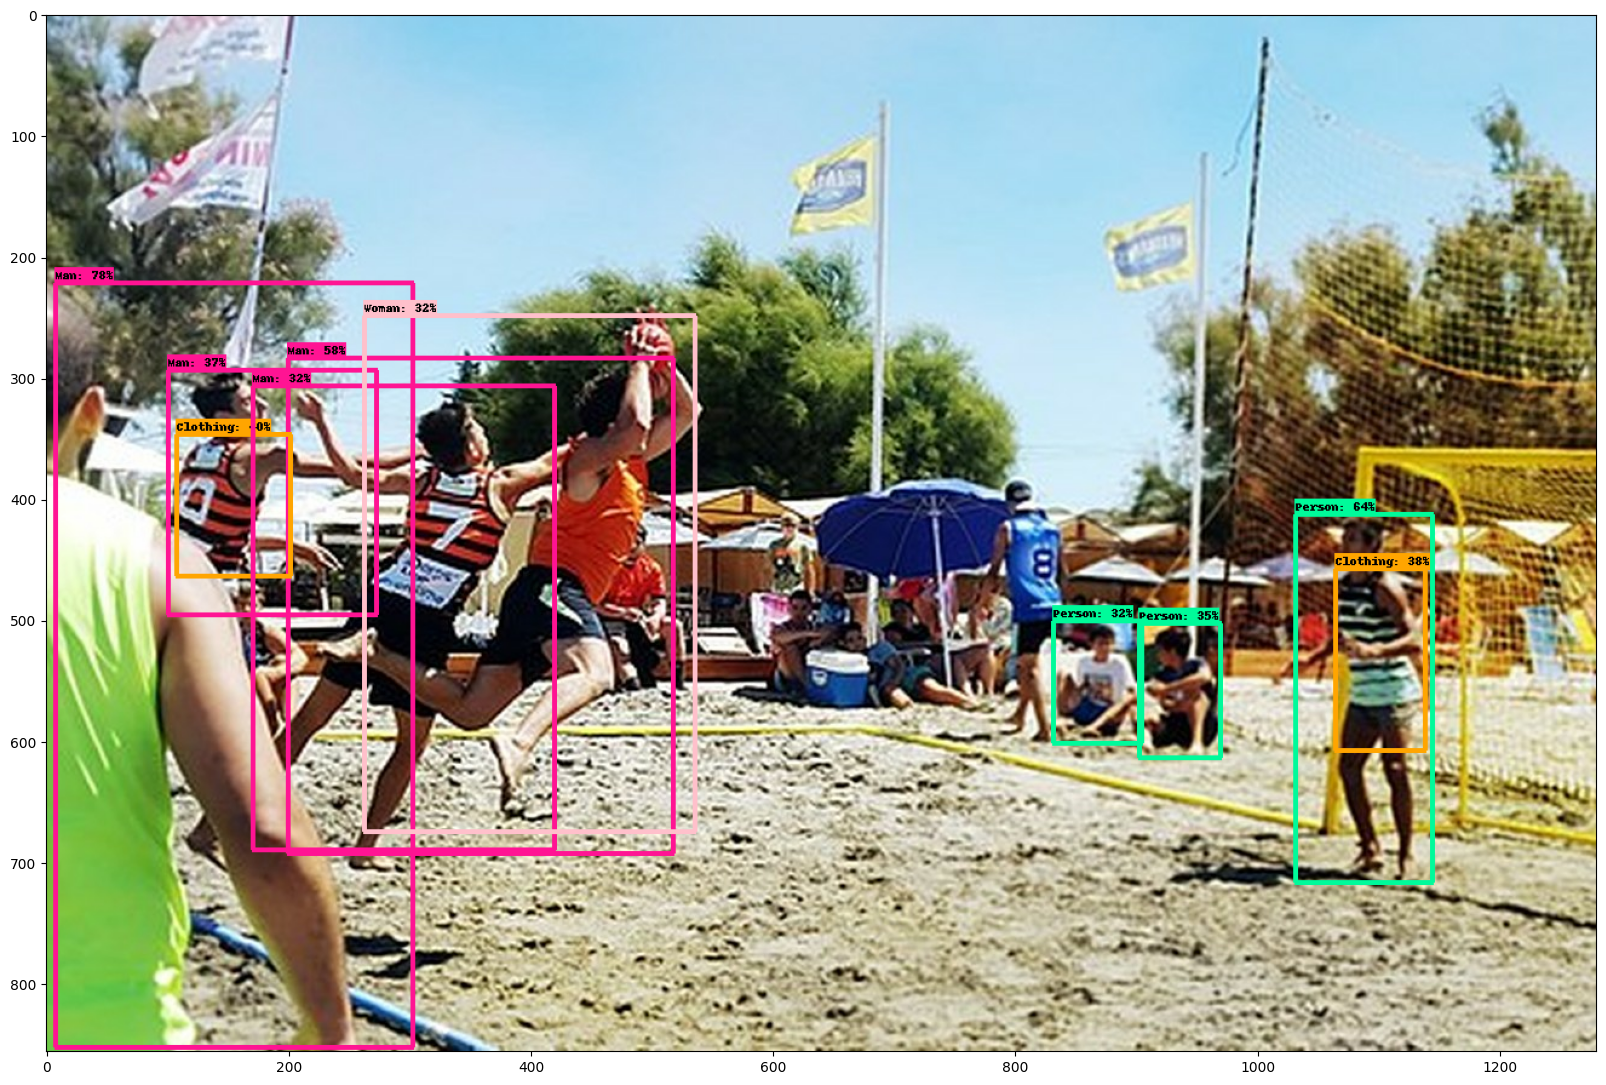

In [20]:
run_detector(detector, downloaded_image_path)

## 문제 2-1. 다른 이미지 테스트해보기


In [ ]:
# 이미지 불러오기
image_url = "https://media.newyorker.com/photos/5fa9c90fa1c3773a925b41a9/16:9/w_4623,h_2600,c_limit/Nissan-were-in-the-park.jpg"
downloaded_image_path = download_and_resize_image(image_url, 896, 599, True)


In [ ]:
# 테스트
run_detector(detector, downloaded_image_path)

# 문제 2-2. 다양한 Pre-Trained Model 테스트해보기 (EfficientDet-d0 Model)


# 모델성과비교 : Faster RCNN VS EfficientDet-d0

In [ ]:
print("1번째 모델인 Inception ResNet을 사용한 Faster RCNN은 조금 느리지만 높은 정확성을 보였습니다. 세세한 오버랩 클래스 구분") 
print("2번째 모델인 EfficientDet-d0 은 빠르게 객체 인지하고 더 다양한 사람 포착. 특정 클래스에서 객체의 객체에 대해서는 더 우수한 정확성을 보여줌. 오버랩(신발 등)은 세밀한 부분은 아쉬울 수 있겠으나 더 중요하고 직관적인 정보의 누락은 FRCNN이 더 컸음.")

1번째 모델인 Inception ResNet을 사용한 Faster RCNN은 조금 느리지만 높은 정확성을 보였습니다. 세세한 오버랩 클래스 구분
2번째 모델인 EfficientDet-d0 은 빠르게 객체 인지하고 더 다양한 사람 포착. 특정 클래스에서 객체의 객체에 대해서는 더 우수한 정확성을 보여줌. 오버랩(신발 등)은 세밀한 부분은 아쉬울 수 있겠으나 더 중요하고 직관적인 정보의 누락은 FRCNN이 더 컸음.


![FRCNN EFFICIENTDET 비교.png](<attachment:FRCNN EFFICIENTDET 비교.png>)
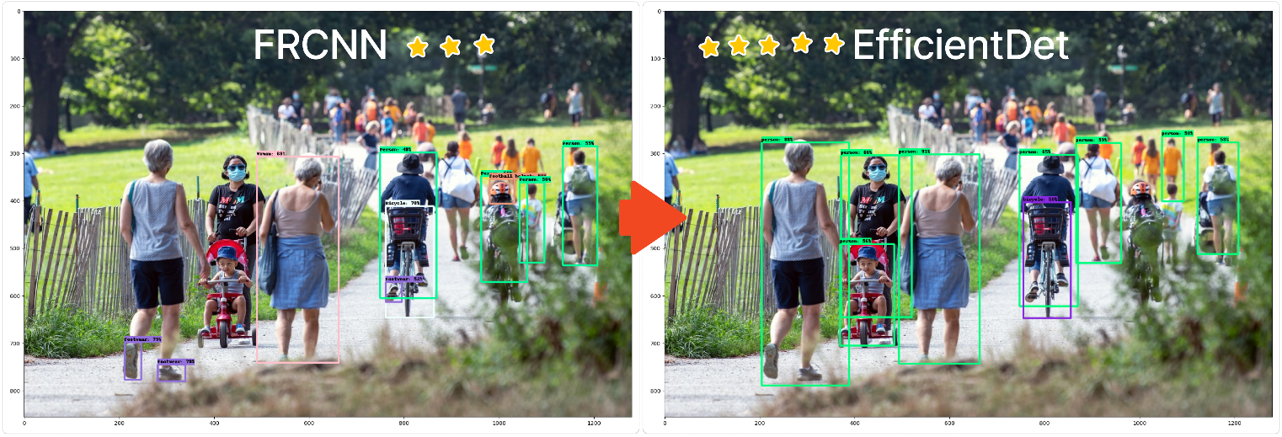

# 회고 : (위에 모델별 이미지 비교 참고하세요.)
- EfficientDet-d0 은 빠르게 객체 인지하고 더 다양한 사람 포착. 
- 특정 클래스에서 객체의 객체에 대해서는 더 우수한 정확성을 보여줌. 다양한 사람에 대한 학습이 EffcientDet가 더 잘 pretrained 돼 있음
- 오버랩(신발 등)은 세밀한 부분은 아쉬울 수 있겠으나 더 크고 중요하고 직관적인 정보의 누락은 FRCNN이 더 컸음. 
- FRCNN은 두 명의 신발을 포착은 했으나 가장 가까운 위치의 할머니와 유모차아이와 선글라스낀 애 엄마 그리고 원거리의 중간지점에 덩치 큰 애 엄마 등(Efficient에서는 모두 detect)을 모두 감지 하지 못함.
- 그러나 헬멧이나 자전거 페달위에 놓인 발을 인식하는 등의 디테일은 FRCNN이 우위

### 성과비교 시각화를 시도했으나 계속되는 오류로 ongoing

In [59]:
# 문제 2-2. 모델 불러오기 (SSD MobileNet)
module_handle = "https://tfhub.dev/tensorflow/efficientdet/d0/1"
detector = hub.load(module_handle).signatures['serving_default']

In [77]:
# EfficientDet-d0 모델

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tempfile 
from six.moves.urllib.request import urlopen
from six import BytesIO
import numpy as np
from PIL import Image, ImageColor, ImageDraw, ImageFont, ImageOps
import time
import os
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

# COCO 데이터셋 클래스 이름 리스트
coco_labels = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
    'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
    'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
    'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
    'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop',
    'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
    'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# 이미지 시각화 함수
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)

# 이미지 다운로드 및 리사이징 함수
def download_and_resize_image(url, new_width=256, new_height=256, display=False): 
    _, filename = tempfile.mkstemp(suffix=".jpg")
    response = urlopen(url)
    image_data = response.read()
    image_data = BytesIO(image_data)  # 이미지 읽기
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.Resampling.LANCZOS) # 이미지 조정
    pil_image_rgb = pil_image.convert("RGB") # RGB로 변환
    pil_image_rgb.save(filename, format="JPEG", quality=90) # 이미지 저장
    print("Image downloaded to %s." % filename)
    if display:
        display_image(pil_image)
    return filename

# Bounding Box 함수
def draw_bounding_box_on_image(image, 
                               ymin, xmin, ymax, xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)

    # BBox 테두리 그리기
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
              width=thickness,
              fill=color)

    display_str_heights = [font.getbbox(ds)[3] - font.getbbox(ds)[1] for ds in display_str_list]
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
    
    for display_str in display_str_list[::-1]:
        bbox = font.getbbox(display_str)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]
        margin = np.ceil(0.05 * text_height)
        
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                       (left + text_width, text_bottom)],
                      fill=color)
        
        draw.text((left + margin, text_bottom - text_height - margin),
                 display_str,
                 fill="black",
                 font=font)
        text_bottom -= (text_height + margin)

    return image

# Box 그리기
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1): 
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    # BBox 그리기 적용
    for i in range(min(len(boxes), max_boxes)):
        score = float(scores[i])  # float로 변환
        if score >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])  # 박스 좌표값
            display_str = "{}: {}%".format(class_names[i],
                                         int(100 * score))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
                image_pil,
                ymin,
                xmin,
                ymax,
                xmax,
                color,
                font,
                display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img  

def run_detector(detector, path):
    img = load_img(path) 

    converted_img = tf.expand_dims(img, 0)

    # 소요시간 측정
    start_time = time.time()
    result = detector(converted_img)  
    end_time = time.time()

    # 모델 출력 키 확인
    print("Model output keys:", result.keys())

    try:
        # 모델 출력 결과를 numpy 형식으로 변환
        result = {key: value.numpy() for key, value in result.items()}

        # 배치 차원 제거 및 리스트로 변환
        boxes = result['detection_boxes'][0].tolist()              
        classes = result['detection_classes'][0].astype(int).tolist() 
        scores = result['detection_scores'][0].tolist()            

        print("Found %d objects." % len(scores))
        print("Inference time: ", end_time - start_time)

        # 클래스 ID를 클래스 이름으로 매핑
        class_names = []
        for class_id in classes:
            if 1 <= class_id <= len(coco_labels):
                class_names.append(coco_labels[class_id - 1])  # 클래스 ID는 1부터 시작
            else:
                class_names.append('N/A')

        # 이미지에 박스 그리기
        image_with_boxes = draw_boxes(
            img.numpy(), boxes, class_names, scores, max_boxes=10, min_score=0.5)

        display_image(image_with_boxes)

    except KeyError as e:
        print(f"KeyError: {e}. 모델의 출력 키를 확인해주세요.")

In [ ]:
# 이미지 불러오기
image_url = "https://media.newyorker.com/photos/5fa9c90fa1c3773a925b41a9/16:9/w_4623,h_2600,c_limit/Nissan-were-in-the-park.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

In [ ]:
# 문제 2-2. 테스트 
run_detector(detector, downloaded_image_path)

run_detector 함수

In [112]:
def run_detector(detector, path, model_name, min_score=0.5):
    img = load_img(path)  
    
    if model_name == "Faster R-CNN (Inception ResNet)":
        print("Converting image to float32 for Faster R-CNN")
        img = tf.image.convert_image_dtype(img, tf.float32)  # Faster R-CNN은 float32 변환
        input_key = 'image_tensor'
    elif model_name == "EfficientDet-d0":
        print("Keeping image as uint8 for EfficientDet-d0") # EfficientDet는 uint8 타입 유지
        input_key = 'input_tensor'
    else:
        print("Unknown model, proceeding with uint8 and 'input_tensor'")
        input_key = 'input_tensor'
    
    # 데이터 타입과 형상 확인
    print(f"Image dtype before expansion: {img.dtype}")
    print(f"Image shape before expansion: {img.shape}")
    
    converted_img = tf.expand_dims(img, 0)  # [1, height, width, 3]
    
    print(f"Converted image shape: {converted_img.shape}, dtype: {converted_img.dtype}")
    
    # 소요시간 측정
    start_time = time.time()
    
    # 모델 호출 시 keyword argument 사용
    try:
        # 모델의 서명에 맞게 keyword argument로 입력
        result = detector(**{input_key: converted_img})
    except TypeError as e:
        print(f"TypeError when calling detector: {e}")
        return None
    except Exception as e:
        print(f"Exception when calling detector: {e}")
        return None
    
    end_time = time.time()
    
    # 모델 출력 키 확인
    print(f"{model_name} 모델 출력 키:", result.keys())
    
    metrics = {}
    
    try:
        # 모델 출력 결과를 numpy 형식으로 변환
        result = {key: value.numpy() for key, value in result.items()}
        
        boxes = result['detection_boxes'][0].tolist()              
        classes = result['detection_classes'][0].astype(int).tolist()   
        scores = result['detection_scores'][0].tolist()            
        
        class_names = []
        for class_id in classes:
            if 1 <= class_id <= len(coco_labels):
                class_names.append(coco_labels[class_id - 1])  
            else:
                class_names.append('N/A')
        
        # 신뢰도 임계값 이상인 객체 필터링
        filtered_indices = [i for i, score in enumerate(scores) if score >= min_score]
        filtered_boxes = [boxes[i] for i in filtered_indices]
        filtered_class_names = [class_names[i] for i in filtered_indices]
        filtered_scores = [scores[i] for i in filtered_indices]
        
        # 이미지에 박스 그리기
        image_with_boxes = draw_boxes(
            img.numpy(), filtered_boxes, filtered_class_names, filtered_scores, max_boxes=10, min_score=min_score)
        
        display_image(image_with_boxes)  
        
        # 성능 메트릭 수집
        metrics['model'] = model_name
        metrics['inference_time_sec'] = end_time - start_time
        metrics['num_detections'] = len(filtered_scores)
        metrics['average_score'] = np.mean(filtered_scores) if filtered_scores else 0.0
        
        return metrics
    
    except KeyError as e:
        print(f"KeyError: {e}. 모델의 출력 키를 확인해주세요.")
        return None

In [108]:
print(inspect.signature(run_detector))  # 변수명 확인

(detector, path, model_name, min_score=0.5)


모델 로드 함수 정의


In [113]:
# 모델 로드 함수 정의
def load_model(model_url, signature='serving_default'):
    """
    모델을 로드하는 함수.
    
    Parameters:
    - model_url (str): TensorFlow Hub에서 모델의 URL.
    - signature (str): 사용할 서명의 이름.
    
    Returns:
    - detector: 로드된 모델의 서명.
    """
    print(f"{model_url} 모델 다운로드 시작...")
    detector = hub.load(model_url).signatures[signature]
    print(f"{model_url} 모델 다운로드 및 로드 완료!")
    return detector

# 모델 URL 정의
faster_rcnn_url = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
efficientdet_d0_url = "https://tfhub.dev/tensorflow/efficientdet/d0/1"

# 모델 로드
faster_rcnn_detector = load_model(faster_rcnn_url, signature='default')  # Faster R-CNN은 'default' 서명 사용
efficientdet_d0_detector = load_model(efficientdet_d0_url, signature='serving_default')  # EfficientDet-d0는 'serving_default' 서명 사용

https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1 모델 다운로드 시작...
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1 모델 다운로드 및 로드 완료!
https://tfhub.dev/tensorflow/efficientdet/d0/1 모델 다운로드 시작...


https://tfhub.dev/tensorflow/efficientdet/d0/1 모델 다운로드 및 로드 완료!


In [117]:
print("Faster R-CNN Detector Signature:")
print(faster_rcnn_detector.structured_input_signature)

print("\nEfficientDet-d0 Detector Signature:")
print(efficientdet_d0_detector.structured_input_signature)

Faster R-CNN Detector Signature:
((), {'images': TensorSpec(shape=(1, None, None, 3), dtype=tf.float32, name='images')})

EfficientDet-d0 Detector Signature:
((), {'input_tensor': TensorSpec(shape=(1, None, None, 3), dtype=tf.uint8, name='input_tensor')})


In [ ]:
# Central Park 이미지 URL
central_park_url = "https://media.newyorker.com/photos/5fa9c90fa1c3773a925b41a9/16:9/w_4623,h_2600,c_limit/Nissan-were-in-the-park.jpg"

# 이미지 다운로드 및 저장
central_park_image_path = download_and_resize_image(central_park_url, new_width=1280, new_height=856, display=True)

In [ ]:
# 메트릭 수집을 위한 리스트 초기화
metrics_list = []

# Faster R-CNN 모델 실행
metrics_frcnn = run_detector(
    detector=faster_rcnn_detector, 
    path=central_park_image_path, 
    model_name="Faster R-CNN (Inception ResNet)", 
    min_score=0.5
)
if metrics_frcnn:
    metrics_list.append(metrics_frcnn)

# EfficientDet-d0 모델 실행
metrics_efficientdet = run_detector(
    detector=efficientdet_d0_detector, 
    path=central_park_image_path, 
    model_name="EfficientDet-d0", 
    min_score=0.5
)
if metrics_efficientdet:
    metrics_list.append(metrics_efficientdet)

In [119]:
# metrics_list 존재 여부 및 내용 확인
if 'metrics_list' in locals() and metrics_list:
    print(f"metrics_list에 {len(metrics_list)}개의 성과 데이터가 있습니다.")
    print(metrics_list)
else:
    print("metrics_list가 비어있거나 정의되지 않았습니다.")

metrics_list에 1개의 성과 데이터가 있습니다.
[{'model': 'EfficientDet-d0', 'inference_time_sec': 1.2132596969604492, 'num_detections': 9, 'average_score': np.float64(0.6570217675632901)}]


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# metrics_list가 비어있지 않은지 다시 확인
if 'metrics_list' in locals() and metrics_list:
    # DataFrame으로 변환
    metrics_df = pd.DataFrame(metrics_list)
    
    # 성과 데이터 출력
    print("=== 성과 메트릭 비교 ===")
    print(metrics_df)
    
    # 그래프 스타일 설정
    sns.set(style="whitegrid")
    
    # 추론 시간 비교 막대 그래프
    plt.figure(figsize=(8, 6))
    sns.barplot(x='model', y='inference_time_sec', data=metrics_df, palette="viridis")
    plt.title('모델별 추론 시간 비교')
    plt.ylabel('추론 시간 (초)')
    plt.xlabel('모델')
    plt.show()
    
    # 탐지된 객체 수 비교 막대 그래프
    plt.figure(figsize=(8, 6))
    sns.barplot(x='model', y='num_detections', data=metrics_df, palette="magma")
    plt.title('모델별 탐지된 객체 수 비교')
    plt.ylabel('탐지된 객체 수')
    plt.xlabel('모델')
    plt.show()
    
    # 평균 신뢰도 점수 비교 막대 그래프
    plt.figure(figsize=(8, 6))
    sns.barplot(x='model', y='average_score', data=metrics_df, palette="coolwarm")
    plt.title('모델별 평균 신뢰도 점수 비교')
    plt.ylabel('평균 신뢰도 점수')
    plt.xlabel('모델')
    plt.show()
    
    # 모델 성능 요약 출력
    print("\n=== 모델 성능 요약 ===")
    summary = metrics_df.groupby('model').agg({
        'inference_time_sec': ['mean', 'std'],
        'num_detections': ['mean', 'std'],
        'average_score': ['mean', 'std']
    }).reset_index()
    
    print(summary)
else:
    print("metrics_list가 비어있거나 정의되지 않았습니다. 모델을 다시 실행하여 성과 데이터를 수집해주세요.")